# Atomic Tools Library 
This jupyter notebook demonstrate different examples using ATL module. 

In [1]:
import atl # Atomic Tools Libary
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

%matplotlib inline
plt.style.use('ggplot')
# print(plt.style.available)

## Reading lammps log file

In [2]:
data, tags = atl.read_log(filename="log.lammps", run=1)

print(tags)
print (data[:3])

['Step', 'Temp', 'TotEng', 'v_dens', 'v_E', 'v_K', 'v_P']
[[0.0, 1.0, -14.083351, 0.038165632, -0.021146172, 0.0029763344, -0.024122506], [1000.0, 46.526908, 65.932951, 0.038165632, 0.098998425, 0.13847964, -0.039481212], [2000.0, 50.68053, 85.817303, 0.038165632, 0.12885481, 0.1508422, -0.021987393]]


Index(['Step', 'Temp', 'TotEng', 'v_dens', 'v_E', 'v_K', 'v_P', 'Time'], dtype='object')


/home/hossein/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


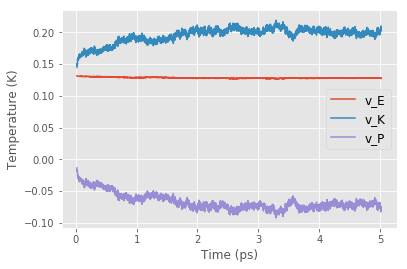

In [3]:
log = atl.read_log_pandas(filename="log.lammps", run=3) # reading into pandas
log['Time'] = 1E-6 * log['Step']

print(log.columns)

# log.plot('time','Temp')
log.plot('Time',['v_E', 'v_K', 'v_P'])

plt.ylabel('Temperature (K)')
plt.xlabel('Time (ps)')
plt.legend(fontsize=12)

## Reading .xyz file format

In [4]:
grn = atl.read_xyz_pandas('grn.xyz')
grn.head()

,t,x,y,z
0,C,-1.842003,-3.545019,0.0
1,C,-3.070027,-2.836020,0.0
2,C,-3.070027,-1.418020,0.0
3,C,-1.842003,-0.709021,0.0
4,C,0.614044,-3.545019,0.0


(-3.377033, 4.4219669999999995, -3.8995189999999997, 3.8994809999999998)

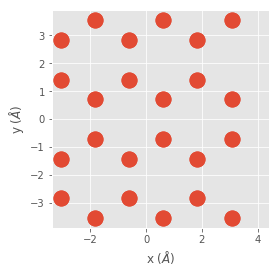

In [5]:
plt.plot(grn.x, grn.y, 'o', ms=15)

plt.ylabel('y ($\AA$)')
plt.xlabel('x ($\AA$)')
plt.axis('square')

## Smoothing data

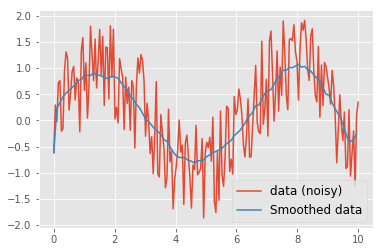

In [6]:
np.random.seed(1234)
x  = np.linspace(0.0,10.0,200)
y  = np.sin(x)+2*(np.random.rand(len(x))-0.5)
xs, ys = atl.smooth_data(x, y, n_ave=20, step=2)

plt.plot(x, y, label='data (noisy)')
plt.plot(xs, ys, label='Smoothed data')
plt.legend(fontsize=12)

## Molecular Frame
Modifying lammps input data file using *Molecular Frame* class

In [7]:
water = atl.MolecularFrame()
water.read_lmp('water.data') # reading lammps input file including atoms, bonds, angles, etc.

print ("Number of molecules:", water.n_molecules)
print ("Number of atoms:", water.n_atoms)
print ("Number of bonds:", water.n_bonds)
print ("Number of angles:", water.n_angles)
print ("Box: Lx(%1.2f) Ly(%1.2f) Lz(%1.2f)"%(water.lx, water.ly, water.lz))

Number of molecules: 293
Number of atoms: 879
Number of bonds: 586
Number of angles: 293
Box: Lx(15.00) Ly(31.00) Lz(22.00)


# Moving atoms

In [8]:
water.move_atoms([1.0, 1.0, 0.0])

### Center of mass & re-centering

In [9]:
print ("Center of mass:", water.center_of_mass)
water.recenter() # recentering to [0.0, 0.0, 0.0] (default)
print ("Center of mass:", water.center_of_mass)

Center of mass: [8.460467785745951, 20.44887050684226, 11.889981917376984]
Center of mass: [6.760163414868245e-14, 1.4015847906811192e-13, 8.585341409074158e-14]


### Selecting molecules in a specified region

In [10]:
def droplet(x, y, z):
    if (np.sqrt(x**2+y**2+z**2)<10.0):  # or adding "and (z>0.0):"
        return True # inside the region
    else: 
        return False # outside the region
    
water_droplet = water.select_molecules_in_region(region_func=droplet) # the region function as input argument
print ("Number of molecules (droplet):", water_droplet.n_molecules)

Number of molecules (droplet): 105


<img src="water_droplet.png" width="300">

### Randomly selected molecules

In [11]:
water_sel = water.select_molecules_randomly(nmol=water_droplet.n_molecules)
print ("Number of molecules (randomly selected):", water_droplet.n_molecules)

Number of molecules (randomly selected): 105


### Merging two molecules

In [12]:
# ... e.g. channel = clay + water

### Saving output molcular frame

In [13]:
water_droplet.write_xyz('droplet.out.xyz')

## Cross LJ parameters 
(suitable for LAMMPS)

In [14]:
clay_param={
    'ao':[70, 1.3297e-06, 4.27132],
    'st':[71, 1.8402e-06, 3.30196],
    'obc':[72, 0.155416, 3.1655200],
    'oh':[73, 0.155416, 3.1655200],     
    'ho':[74, 0.000000, 0.0000000],
    'mgo':[75, 9.0298e-07, 5.90900],
    'K': [76, 0.100000, 3.7423000],
    'hw':[77,0.000000, 0.0000000],
    'ow':[78, 0.155400, 3.5532000]
}
    
benzene_param={
    'H':[20, 2.829367882355780447E-02, 2.373408142809749322E+00],
    'C':[63, 7.345736105118740034E-02, 3.520525192477496734E+00]
}

In [15]:
atl.intermol_lj_param(clay_param, benzene_param, ignore_self_interact=True)

# Generated by ATL "intermol_lj_param()"
pair_coeff    20    70 0.0001939642 3.3223640714 # ao-H
pair_coeff    63    70 0.0003125320 3.8959225962 # ao-C
pair_coeff    20    71 0.0002281798 2.8376840714 # st-H
pair_coeff    63    71 0.0003676632 3.4112425962 # st-C
pair_coeff    20    72 0.0663120682 2.7694640714 # obc-H
pair_coeff    63    72 0.1068477853 3.3430225962 # obc-C
pair_coeff    20    73 0.0663120682 2.7694640714 # oh-H
pair_coeff    63    73 0.1068477853 3.3430225962 # oh-C
pair_coeff    20    74 0.0000000000 1.1867040714 # ho-H
pair_coeff    63    74 0.0000000000 1.7602625962 # ho-C
pair_coeff    20    75 0.0001598394 4.1412040714 # mgo-H
pair_coeff    63    75 0.0002575471 4.7147625962 # mgo-C
pair_coeff    20    76 0.0531918028 3.0578540714 # K-H
pair_coeff    63    76 0.0857072698 3.6314125962 # K-C
pair_coeff    20    77 0.0000000000 1.1867040714 # hw-H
pair_coeff    63    77 0.0000000000 1.7602625962 # hw-C
pair_coeff    20    78 0.0663086547 2.9633040714 # ow-H
pair_

## RDF calculations

### Directly calling Fortran subroutine

In [2]:
import os
os.system("f2py -c ../atl/rdf_fort.f90 -m ../atl/rdf_fort")
import atl.rdf_fort 

atl.rdf_fort.calc_rdf_fort(file_name='dump.xyz',
                   pbc_box=[19.246222, 19.246222, 19.246222],
                   nr_mesh=100, 
                   r_cutoff=9.0, 
                   lateral=False, 
                   delta_z=1.0, 
                   sel_type='2', 
                   start_frame=50, 
                   stop_frame=1000000, 
                   step_frame=1)

### Using ATL wrapper

In [10]:
atl.calculate_rdf(file_name='dump.xyz', sel_type='2', pbc_box=[19.246222, 19.246222, 19.246222], r_cutoff=9)

Text(0.5,0,'r ($\\AA$)')

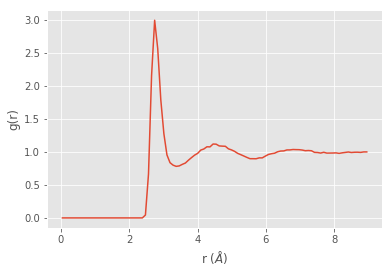

In [12]:
gr = np.loadtxt('gr.dat')
# print(gr)
plt.plot(gr[:,0], gr[:,1])

plt.ylabel('g(r)')
plt.xlabel('r ($\AA$)')